# Pip install statements
All packages needed to run the notebook

In [1]:
!pip install torch

!pip install numpy
!pip install torchinfo
!pip install matplotlib
!pip install scikit-learn
!pip install pandas
!pip install matplotlib.pyplot
!pip install yfinance

ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 45.3 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 83.6 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 kB 49.1 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.5-py3-none-any.whl size=138635 sha256=cb4b331d2f495ba97541bc4311588cbc613ec783aa28ac658d7ebab185d8b824
  Stored in directory: /root/.cache/pip/wheels/d2/cb/9c/c300d7bf782e07f1658c306743d5e30af7e4834001e4064a96
Successfully built peewee
 

# Imports
All packages required to run the notebook

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.functional as F

from torch.utils.data import *

from sklearn.preprocessing import MinMaxScaler

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf

import copy
import os

from pathlib import Path

# Save Model
Method we will use later to save the model we trained

In [4]:
def saveModel(model, name):
    # Directory Name
    directory = './models/'
    # Create models folder and checks if it exists
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory {directory} created successfully...")
    # Define path and name
    path = os.path.join(directory, name)
    # Save model
    torch.save(model, path)
    print(f"{name} saved succesfully")

# Data Processing
Given sets of pairs these three methods will split the data into a train and validation dataset.

In [5]:
# Time step to predict ahead, creates input sequences and output seqences for a single pair
def create_lstm_data(data, time_step=1, future = 0):
    """Splits given stock data into a X, y dataset

    Args:
        data (Tensor): Pytorch tensor containing the time series data
        time_step (int, optional): Amount of timesteps of input for model to train on. Defaults to 1.
        future (int, optional): Amount of timesteps that will be predicted. Defaults to 0.

    Returns:
        _type_: _description_
    """
    x_vec, y_vec = [], []
    # Formats data so y = t and x = t-1, ... , t-time_steps
    for i in range(len(data) - time_step):
        split = i + time_step
        # Checks if data is of same length for concatentation, to prevent errors
        length = data[split : split + future, 0].shape[0]
        if(length == future):
            x_vec.append(data[i : split, 0].unsqueeze(0))
            y_vec.append(data[split : split + future, 0].unsqueeze(0))
    # Concats x into matrix and y into vector, needs unsqueeze to add single dimension for LSTM dimensions
    return torch.cat(x_vec,0).unsqueeze(-1), torch.cat(y_vec,0).unsqueeze(-1)

# Create a Pytorch dataset out of timeseries data
class TimeSeriesDataset(Dataset):
    """Creates a Pytorch dataset out of a given X and Y

    Args:
        Dataset : Inherits parameters of Pytorch dataset class
    """
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,i):
        return self.X[i], self.y[i]

# Given multiple sets of pairs outputs a concatenated train and test dataset containing data from all pairs
def create_train_dataset(pairs, input_size, output_size, train_test_ratio = 0.8):
    """Given set of pairs this creates a train and test dataset to train and test the model on

    Args:
        pairs (string, string): Pair of stocks
        input_size (int): Window of days to train on
        output_size (int): Window of days to predict
        train_test_ratio (float): Percent of data to be assign to train and test

    Returns:
        Dataset: Dataset of all pairs to train on
    """
    
    train_dataset_list = []
    test_dataset_list = []
    
    scaler = MinMaxScaler(feature_range=(0,1))
    
    for (x, y) in pairs:
        # Get the spread for a pair
        x_data = yf.download(x, period='10y')['Close']
        y_data = yf.download(y, period='10y')['Close']
        spread = x_data - y_data
        spread = spread.values.reshape(-1,1)
        
        # Normalize the data
        normalized_data = torch.tensor(scaler.fit_transform(spread))
        train_test_split = (int)(len(normalized_data) * train_test_ratio)
        
        # Split data into train and test
        train_data = normalized_data[:train_test_split]
        test_data = normalized_data[train_test_split:]
        # Create train dataset
        X_train, y_train = create_lstm_data(train_data, input_size, output_size)
        train_dataset_i = TimeSeriesDataset(X_train,y_train)
        train_dataset_list.append(train_dataset_i)
        # Create test dataset
        X_test, y_test = create_lstm_data(test_data, input_size, output_size)
        test_dataset_i = TimeSeriesDataset(X_test,y_test)
        test_dataset_list.append(test_dataset_i)
        
    train_dataset = torch.utils.data.ConcatDataset(train_dataset_list)
    test_dataset = torch.utils.data.ConcatDataset(test_dataset_list)
    
    return train_dataset, test_dataset, scaler

# Model Architecture

The architecture used is the LSTM-Encoder-Decoder Model, in this implementation we are given x number of timestep to encode (the input), and y number of timesteps to decoder (the output). 

In [6]:
# Encoder block of the model
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, dropout = 0.5):
        super(Encoder,self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.input_dim = input_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, n_layers, dropout=dropout,
                           batch_first=True)

    def forward(self, x):
        
        outputs, (hidden, cell) = self.rnn(x)
        
        return hidden, cell
 
# Decoder block of the model   
class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, dropout = 0.5):
        super(Decoder,self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(input_dim, hidden_dim, n_layers, dropout=dropout,
                           )
        self.fc_out = nn.Linear(hidden_dim, 1)

    #predicts a single time step, with either y pred as input or y
    def forward(self, y, prev_hidden, prev_cell):

        y = y.unsqueeze(0)

        output, (hidden, cell) = self.rnn(y, (prev_hidden, prev_cell))

        prediction = self.fc_out(output.squeeze(0))
        
        return prediction, hidden, cell
    
class EncoderDecoderWrapper(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout = 0.5, output_size = 1, teacher_forcing=0.3, device = 'cpu'):
        super(EncoderDecoderWrapper,self).__init__()
        self.encoder = Encoder(input_dim,num_layers,hidden_dim,dropout)
        self.decoder = Decoder(input_dim,num_layers,hidden_dim,dropout)
        self.teacher_forcing = teacher_forcing
        self.device = device
        self.output_size = output_size

    def forward(self, source, target=None):
        
        # Number of elements in each batch
        batch_size = source.shape[0]
        
        # Output should be same size as target during training
        if(target != None):
            target_len = target.shape[1]
        
            assert(target_len == self.output_size)
        
        prev_hidden, prev_cell = self.encoder(source)

        prev_target = source[:,-1]
            
        outputs = torch.zeros(batch_size,self.output_size).to(self.device)
        
        for t in range(self.output_size):
            
            prediction, prev_hidden, prev_cell = self.decoder(prev_target, prev_hidden, prev_cell)

            outputs[:,t] = prediction.squeeze(1)
            
            # Chance of using actual next value vs chance of using predicted in training to predict next value 
            prev_target = target[:,t] if torch.rand(1) < self.teacher_forcing and target != None else prediction
        
        return outputs

# Training Loop
This method composes our training loop that we will use to train the model, each epoch will run this method once and return the training loss, the lower the training loss the better the model is fit to our training data.

In [7]:
def train_epoch(model,dataloader,loss_fn,optimizer,device = 'cpu'):
    
    model.train()
    running_loss = 0.0

    for X, y in dataloader:
        X_train, y_train = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
        
        output = model(X_train, y_train)
        loss = loss_fn(output, y_train.squeeze(2))
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_loss = running_loss / len(dataloader)
    print(f'Train Average Loss: {avg_loss}')
    
    return avg_loss

# Validation Loop
This method composes our validation loop, for every training loop we will run the validation dataset through the model to determine if the model is overfitting, if the validation loss is substantially higher than the training loss we can determine the model is overfitting. The lower the validation loss the better the model will generalize to new unseen data.

In [8]:
# Outputs validation loss
def validation_loss(model,dataloader,loss_fn,device = 'cpu'):
    
    model.eval()
    running_loss = 0.0
    for X, y in dataloader:
        X_test, y_test = X.to(device).to(torch.float32).clone(), y.to(device).to(torch.float32).clone()
        
        output = model(X_test)
        loss = loss_fn(output, y_test.squeeze(2)).item()
        running_loss += loss
    running_loss /= len(dataloader)
    print(f'Validation Loss: {running_loss}')
    
    return running_loss

# Formatting Data
We have created a list of 11 pair for the model to train on and will create a dataset using the previous methods in the notebook. We will then load these datasets into dataloader as this is the format the data needs to be in use batches, which allows for less powerful GPU's to train models efficently.

In [9]:
# Parameters for data
BATCH_SIZE = 128
input_size = 30
output_size = 60

In [10]:
# Pairs to train model on
pairs = [('CSGP','PLD'),("TJX","DLTR"),("AEP",'XEL'),
         ("AMD","NXPI"),("AMD","ADI"),("QCOM","TSM"),("QCOM","NXPI"),
         ("ABBV",'AMGN'),("CRM","WDAY"),("COF","DFS"),("YUM","DRI")]

# Outputs train and validation dataset and scalar transformation to rescale data to original values
train_dataset, valid_dataset, scaler = create_train_dataset(pairs, input_size, output_size)

# Loading training set into a dataloader
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
)
# Loading validation set into a dataloader
valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

# Training
Using the data formatted from above we will train/fit our model. The hyperparameters we choose will greatly affect the performance of the model. In the end we want to see a a validation and training loss that is similar to each other. If there is a large gap between the two this is due to overfitting to the training data.

Note: the validation loss will almost always be higher than the training loss

In [12]:
# Hyper parameters
input_dim = 1 # Keep constant since stock data has one data point per time step
num_layers = 2 # Increases complexity of model, increase if training loss is high
hidden_size = 15 # Increases complexity of model, increase if training loss is high
dropout = 0.5 # Reduces overfitting, if spread between train and validation loss are high increase
teacher_forcing = 0.2

device = device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = EncoderDecoderWrapper(input_dim,num_layers,hidden_size,dropout,output_size,teacher_forcing,device).to(device)

In [13]:
lr = 0.001 # Decrease if loss steadies out, Decrease if loss increases every epoch
num_epochs = 30 # Increase if training loss is high, further fits model to data
loss = nn.MSELoss() # Metric we use to train
v_loss = nn.MSELoss() # Metric we use to train
optimizer = torch.optim.Adam(model.parameters(), lr)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) # Adjust the learning rate by lr * 0.9 every x epochs
scheduler_epoch = 2 # Adjust the learning rate of every mod of this number

Epoch: 0
Train Average Loss: 0.1664692561607808


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:879: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Validation Loss: 0.04976642827710344
Epoch: 1
Train Average Loss: 0.03491029021658385
Validation Loss: 0.04707105287040273
Epoch: 2
Train Average Loss: 0.03427313024273524
Validation Loss: 0.04615664738877159
Epoch: 3
Train Average Loss: 0.03370965536997979
Validation Loss: 0.045631818622091994
Epoch: 4
Train Average Loss: 0.032347874216600715
Validation Loss: 0.043412989729808435
Epoch: 5
Train Average Loss: 0.031150120325212603
Validation Loss: 0.04213911076335029
Epoch: 6
Train Average Loss: 0.026003691189675535
Validation Loss: 0.03920264364246072
Epoch: 7
Train Average Loss: 0.02070096476530903
Validation Loss: 0.030351421524149675
Epoch: 8
Train Average Loss: 0.01781819599360811
Validation Loss: 0.02674170477419264
Epoch: 9
Train Average Loss: 0.016256582012949848
Validation Loss: 0.02486206831720968
Epoch: 10
Train Average Loss: 0.015024220510610345
Validation Loss: 0.023796461496709123
Epoch: 11
Train Average Loss: 0.013662864855232548
Validation Loss: 0.022874777593339484
Epoc

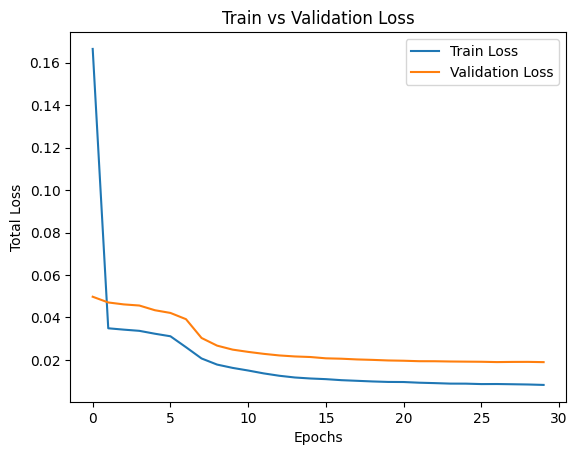

In [14]:
train_loss_i = []
valid_loss_i = []

name = "PairsTradingModel"

for epoch in range(num_epochs):
    print(f'Epoch: {epoch}')
    # Run training loop
    train_loss = train_epoch(model, train_dataloader, loss, optimizer, device)
    # Save training loss
    train_loss_i.append(train_loss)
    # Run validation loop
    valid_loss = validation_loss(copy.deepcopy(model), valid_dataloader, v_loss, device)
    # Save validation loss
    valid_loss_i.append(valid_loss)
    # Learning rate adjustment
    if(epoch % scheduler_epoch == 0 and epoch != 0):
        lr_scheduler.step()
# Plot train and validation loss
plt.plot(train_loss_i, label =  "Train Loss")
plt.plot(valid_loss_i, label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.title("Train vs Validation Loss")
# Save Model
torch.save(model, name)

# Testing
After training the model, we can check the performance of out forcasts. Below we can choose one of the 11 pairs datasets from above and calculate the predicted values from its validation dataset. Using this we can further determine whether we should adjust the hyperparameter further or if the model fits to our liking. 

torch.Size([415, 60]) | torch.Size([415, 30, 1]) | torch.Size([415, 60, 1])


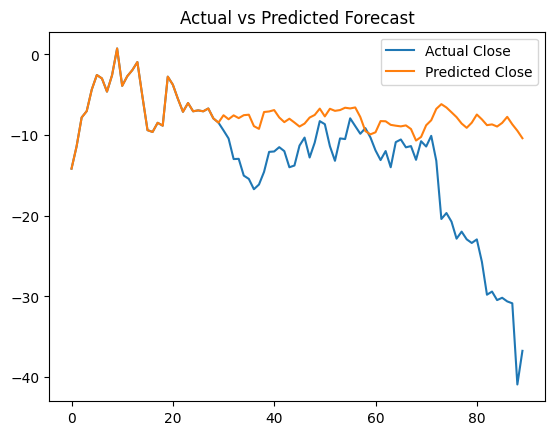

In [15]:
# Which of the 11 datasets to choose from the concatenated dataset
dataset = 5
valid_dataset_i = valid_dataset.datasets[dataset]
# Grab all X's and y's from the dataset
X = valid_dataset_i.X
y = valid_dataset_i.y
# Get predictions
with torch.inference_mode():
    predicted = model(X.to(device).to(torch.float32)).to(device)

# i must be less then 0th dimension of prediction
print(f'{predicted.shape} | {X.shape} | {y.shape}')

i = 150

pred_with_x = torch.concat([X.cpu().squeeze(2),predicted.cpu()],1)
y_with_x = torch.concat([X.cpu().squeeze(2),y.cpu().squeeze(2)],1)

true_y = scaler.inverse_transform(y_with_x)
true_y_pred = scaler.inverse_transform(pred_with_x)

plt.title("Actual vs Predicted Forecast")
plt.plot(true_y[i], label = 'Actual Close')
plt.plot(true_y_pred[i], label = 'Predicted Close')
plt.legend()


# Backtesting
For the backtest we will use an unseen pair that the model has not been trained on to determine if the model generalizes well across new pairs and how well the LSTM-Encoder-Decoder strategy may perform.

In [ ]:
# Using model trained above
model = model
# Loading previously saved model
# MODEL_NAME = f'model1_{num_epochs}.pth' # Name of model
# MODEL_PATH = Path("models") # Path to load model from
# MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
# model = EncoderDecoderWrapper(input_dim,num_layers,hidden_size,dropout,output_size,teacher_forcing,device)
# model.load_state_dict(torch.load(MODEL_SAVE_PATH))
# model = model.to(device)

In [66]:
# Download HMC and MYMTF price data:
hmc_data: pd.Series = yf.download('HMC', period='10y')['Close']
hymtf_data: pd.Series = yf.download('HYMTF', period='10y')['Close']
# Calculate the spread:
spread: pd.Series = hymtf_data - hmc_data

ROLLING_WINDOW = output_size     # This is used for determining how many days ahead to forcast
TRAINING_PERIOD =  input_size  # This is the number of days to use for each prediction
MONEY_PER_TRADE = 50000 # Capital to allocate to each trade in the pairs trade

# Convert capital to shares:
hmc_share_quant = MONEY_PER_TRADE/hmc_data
hymtf_share_quant = MONEY_PER_TRADE/hymtf_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# How Forecasting is Being Used
Currently I am using the fitted LSTM Encoder-Decoder Model we trained previously. We then use this trained model to forcast future values of the spread from a specified point using a previous window of data. The size of these windows are specified by the input and output size of the data we train the model on previously.

From these predicted values we calculate the mean and the standard deviation to determine the bollinger bands and check for arbitrage opportunities.


In [67]:
scaler = MinMaxScaler(feature_range=(0,1))

daily_returns = []
trade_log = []
position_open = False
position_type = None

for date, current_spread in spread.items():
    if date not in hmc_data.index or date < spread.index[TRAINING_PERIOD]:
        continue
    
    reg_index = spread.index.get_loc(date)
    
    
    #Rreshape data to correct shape, normalize data, and convert to tensor
    input_data = torch.FloatTensor(scaler.fit_transform(spread.iloc[reg_index - TRAINING_PERIOD: reg_index].values.reshape(-1,1))).unsqueeze(0)
    
    # Forecast the spread for the next ROLLING_WINDOW days, and transform back to normal values
    with torch.inference_mode():
        output_data = model(input_data)
    forecast_data = torch.tensor(scaler.inverse_transform(output_data))
    # Calculate rolling mean and bands based on forecasted spread
    rolling_mean = torch.mean(forecast_data)
    rolling_std = torch.std(forecast_data)
    upper_band = rolling_mean + (rolling_std * 0.8)
    lower_band = rolling_mean + (rolling_std* 0.8)
    # Convert tensors to regular data type
    mean_value = rolling_mean.item()
    lower_band_value = lower_band.item()
    upper_band_value = lower_band.item()
    
    hmc_price = hmc_data.get(date, None)
    hymtf_price = hymtf_data.get(date, None)
    hmc_shares = hmc_share_quant.get(date, None)
    hymtf_shares = hymtf_share_quant.get(date, None)
    if current_spread < lower_band_value and not position_open:
        # Open a pairs trade position (short HMC, long HYMTF)
        trade_log.append({
            'Date': date,
            'Action': 'Open Position',
            'Type': 'lower',
            'HMC_Shares': hmc_shares,
            'HYMTF_Shares': hymtf_shares,
            'HMC_Price': hmc_price,
            'HYMTF_Price': hymtf_price
        })
        position_open = True
        position_type = 'lower'
        
    elif current_spread > upper_band_value and not position_open:
        # Open a different pairs trade position (long HMC, short HYMTF)
        trade_log.append({
            'Date': date,
            'Action': 'Open Position',
            'Type': 'upper',
            'HMC_Shares': hmc_shares,
            'HYMTF_Shares': hymtf_shares,
            'HMC_Price': hmc_price,
            'HYMTF_Price': hymtf_price
        })
        position_open = True
        position_type = 'upper'
    
    elif current_spread > mean_value and position_open and position_type == 'lower':
        # Close position opened at lower band
        trade_log.append({
            'Date': date,
            'Action': 'Close Position',
            'Type': 'lower',
            'HMC_Shares': hmc_shares,
            'HYMTF_Shares': hymtf_shares,
            'HMC_Price': hmc_price,
            'HYMTF_Price': hymtf_price
        })
        position_open = False
        
    elif current_spread < mean_value and position_open and position_type == 'upper':
        # Close position opened at upper band
        trade_log.append({
            'Date': date,
            'Action': 'Close Position',
            'Type': 'upper',
            'HMC_Shares': hmc_shares,
            'HYMTF_Shares': hymtf_shares,
            'HMC_Price': hmc_price,
            'HYMTF_Price': hymtf_price
        })
        position_open = False

# Save the trade log DataFrame to a csv file for a visual sanity check:
trade_log_df = pd.DataFrame(trade_log)
trade_log_df.to_csv('tradelog.csv')

In [68]:
# Iterate through rows in our trade log DataFrame and calcule the pnl:
total_return = 0
open_position = None
close_position_dates = []
close_position_returns = []
for index, trade in trade_log_df.iterrows():
    if trade['Action'] == 'Open Position':
        open_position = trade
    elif trade['Action'] == 'Close Position' and open_position is not None:
        close_position = trade
        close_position_dates.append(trade['Date'])
        if open_position['Type'] == 'lower':
            hmc_profit_loss = (open_position['HMC_Price'] - trade['HMC_Price']) * (open_position['HMC_Shares'])
            hymtf_profit_loss = (trade['HYMTF_Price'] - open_position['HYMTF_Price']) * (open_position['HYMTF_Shares'])
        elif open_position['Type'] == 'upper':
            hmc_profit_loss = (trade['HMC_Price'] - open_position['HMC_Price']) * (open_position['HMC_Shares'])
            hymtf_profit_loss = (open_position['HYMTF_Price'] - trade['HYMTF_Price']) * (open_position['HYMTF_Shares'])

        total_profit_loss = hmc_profit_loss + hymtf_profit_loss
        total_return += total_profit_loss
        close_position_returns.append(total_profit_loss)

profit_loss_df = pd.DataFrame(close_position_returns, index=close_position_dates, columns=['Profit/Loss'])
profit_loss_df.to_csv('returns.csv')

# Backtest Analysis

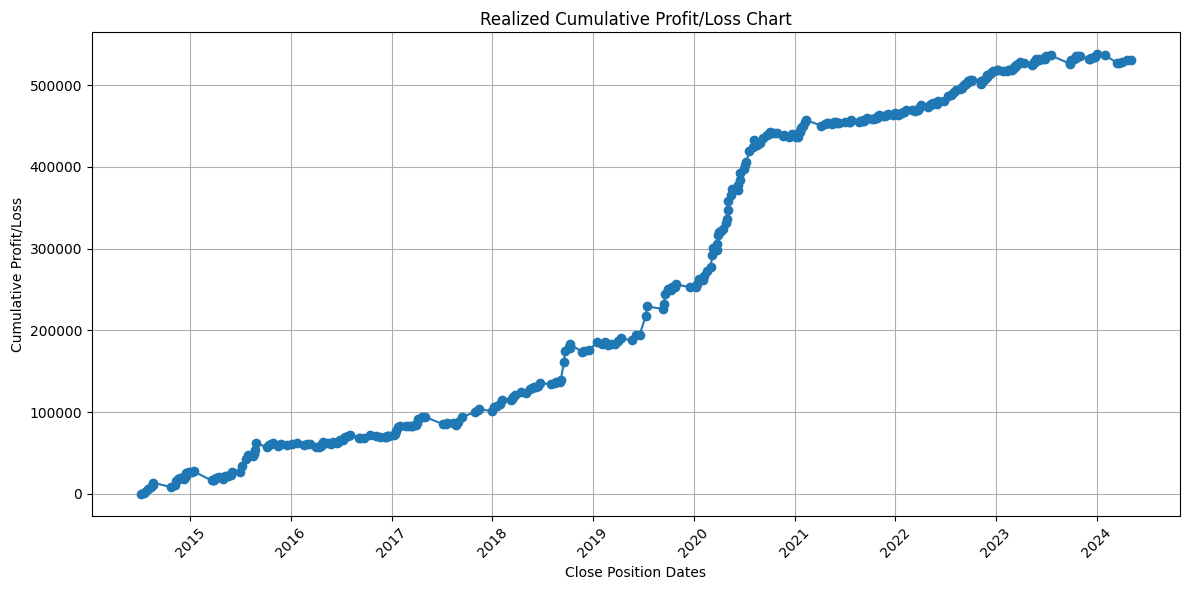

In [69]:
# Calculate the cumulative profit and loss:
profit_loss_df['Cumulative PnL'] = profit_loss_df['Profit/Loss'].cumsum()

# Plot:
plt.figure(figsize=(12, 6))
plt.plot(profit_loss_df.index, profit_loss_df['Cumulative PnL'], marker='o', linestyle='-')
plt.title('Realized Cumulative Profit/Loss Chart')
plt.xlabel('Close Position Dates')
plt.ylabel('Cumulative Profit/Loss')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Annual Sharpe Ratio:
 Year
2014    1.999091
2015    1.441972
2016    1.276405
2017    1.732923
2018    2.607800
2019    2.112232
2020    7.226662
2021    2.314308
2022    5.886571
2023    1.327422
2024   -0.251090
Name: Returns, dtype: float64

Number of Trades per Year:
 Year
2014    19
2015    30
2016    35
2017    25
2018    29
2019    22
2020    44
2021    43
2022    50
2023    40
2024     7
dtype: int64

Average Sharpe Ratio: 2.515844970650968


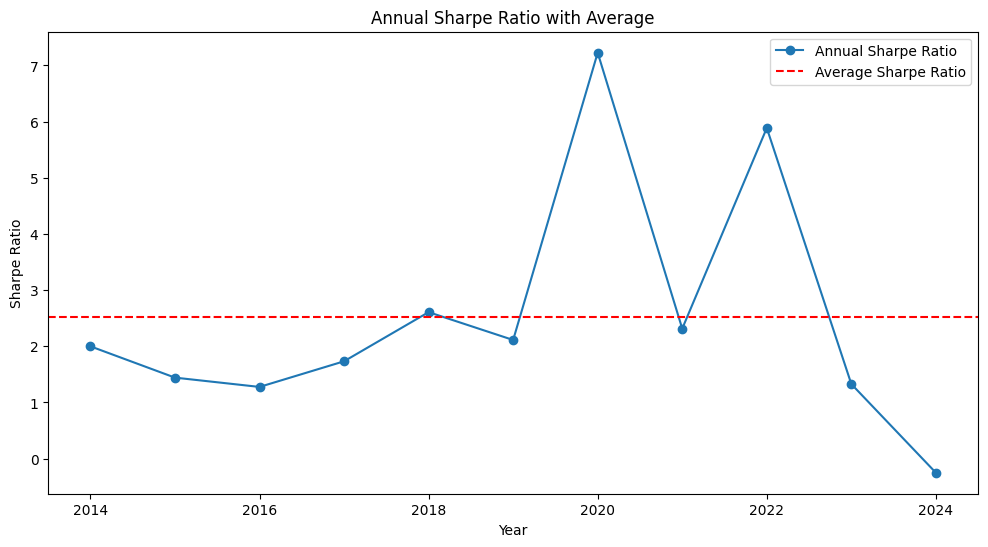

In [70]:
# Convert the PnL to returns:
capital = 100000  # Adjust this as per your initial capital
profit_loss_df['Returns'] = profit_loss_df['Profit/Loss'] / capital

# Group the data by year using the index:
profit_loss_df['Year'] = profit_loss_df.index.year

# Count the trades per year and calculate the average:
trades_per_year = profit_loss_df.groupby('Year').size()
average_trades_per_year = trades_per_year.mean()

# Calculate the annual return as well as the standard deviation:
annual_returns = profit_loss_df.groupby('Year')['Returns'].sum()
annual_std_dev = profit_loss_df.groupby('Year')['Returns'].std() * np.sqrt(average_trades_per_year)
annual_risk_free_rate = 0.01

# Calculate the annual Sharpe Ratio:
annual_sharpe_ratio = (annual_returns - annual_risk_free_rate) / annual_std_dev

# Calculate the average Sharpe Ratio:
average_sharpe_ratio = annual_sharpe_ratio.mean()

# Print info:
print("Annual Sharpe Ratio:\n", annual_sharpe_ratio)
print("\nNumber of Trades per Year:\n", trades_per_year)
print("\nAverage Sharpe Ratio:", average_sharpe_ratio)

# Plot:
plt.figure(figsize=(12, 6))
plt.plot(annual_sharpe_ratio, label='Annual Sharpe Ratio', marker='o')
plt.axhline(y=average_sharpe_ratio, color='r', linestyle='--', label='Average Sharpe Ratio')
plt.title('Annual Sharpe Ratio with Average')
plt.xlabel('Year')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.show()